In [196]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.preprocessing import MinMaxScaler

# Get the Data

In [2]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '2UMBVTUU7P330UMO'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


Data saved to : stock_market_data-AAL.csv


# EDA

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


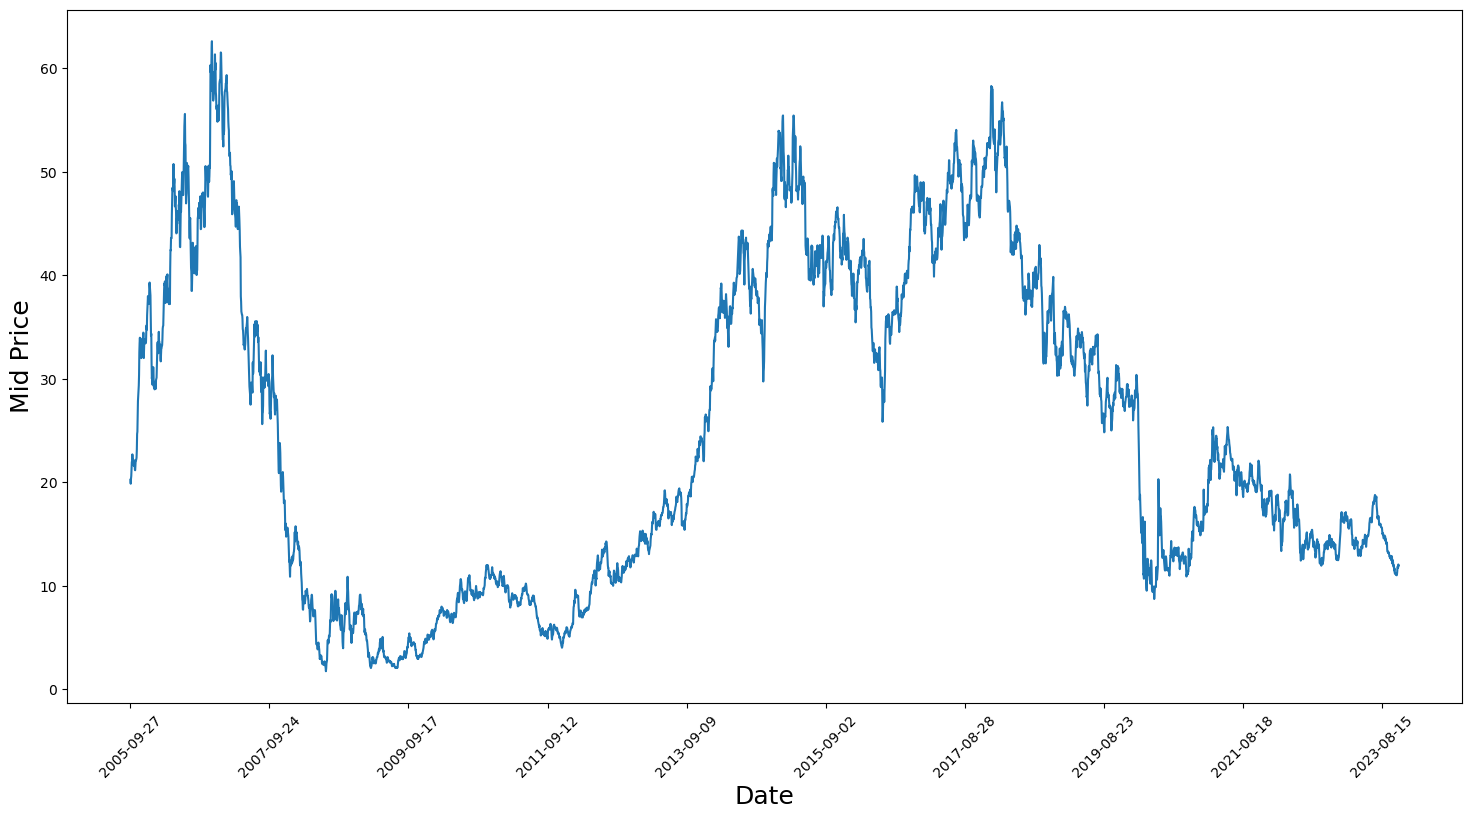

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Data Preprocessing

## Split data into training and testing dataset

In [141]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

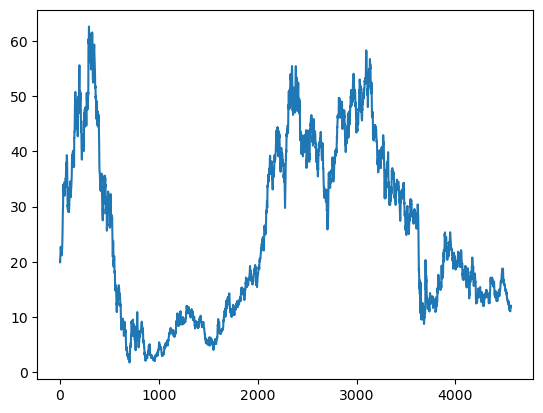

In [132]:
plt.plot(range(df.shape[0]),mid_prices)

In [142]:
train_num = int(df.shape[0]*0.8)
train_data = mid_prices[:train_num]
test_data = mid_prices[train_num:]
train_data.shape[0]

3649

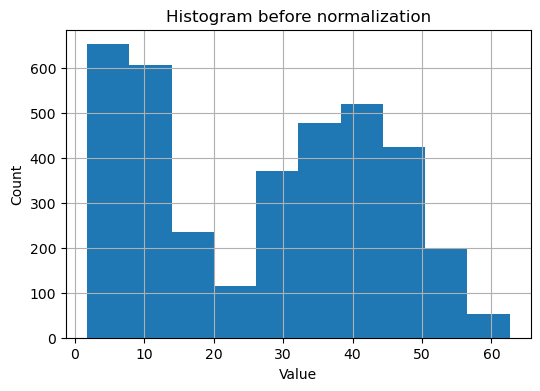

In [143]:
plt.figure(figsize = (6,4))
pd.Series(train_data).hist()
plt.title('Histogram before normalization')
plt.xlabel('Value',fontsize=10)
plt.ylabel('Count',fontsize=10)
plt.show()

## Normalization

In [144]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [145]:
# Train the Scaler with training data and smooth data in specific range
smoothing_window_size = 1000
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

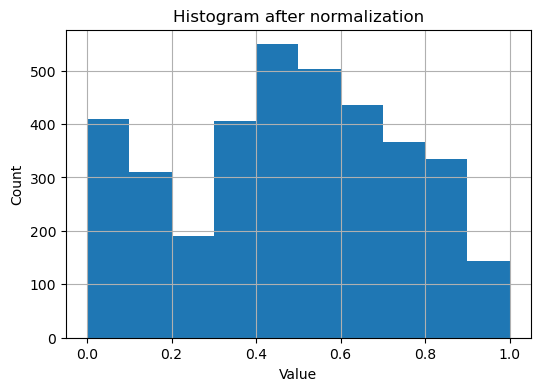

In [146]:
plt.figure(figsize = (6,4))
pd.Series(np.squeeze(train_data,axis=1)).hist()
plt.title('Histogram after normalization')
plt.xlabel('Value',fontsize=10)
plt.ylabel('Count',fontsize=10)
plt.show()

In [147]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [150]:
# Now perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(train_data.shape[0]):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


# Training Process

## 1. Standard Average

In [151]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00342


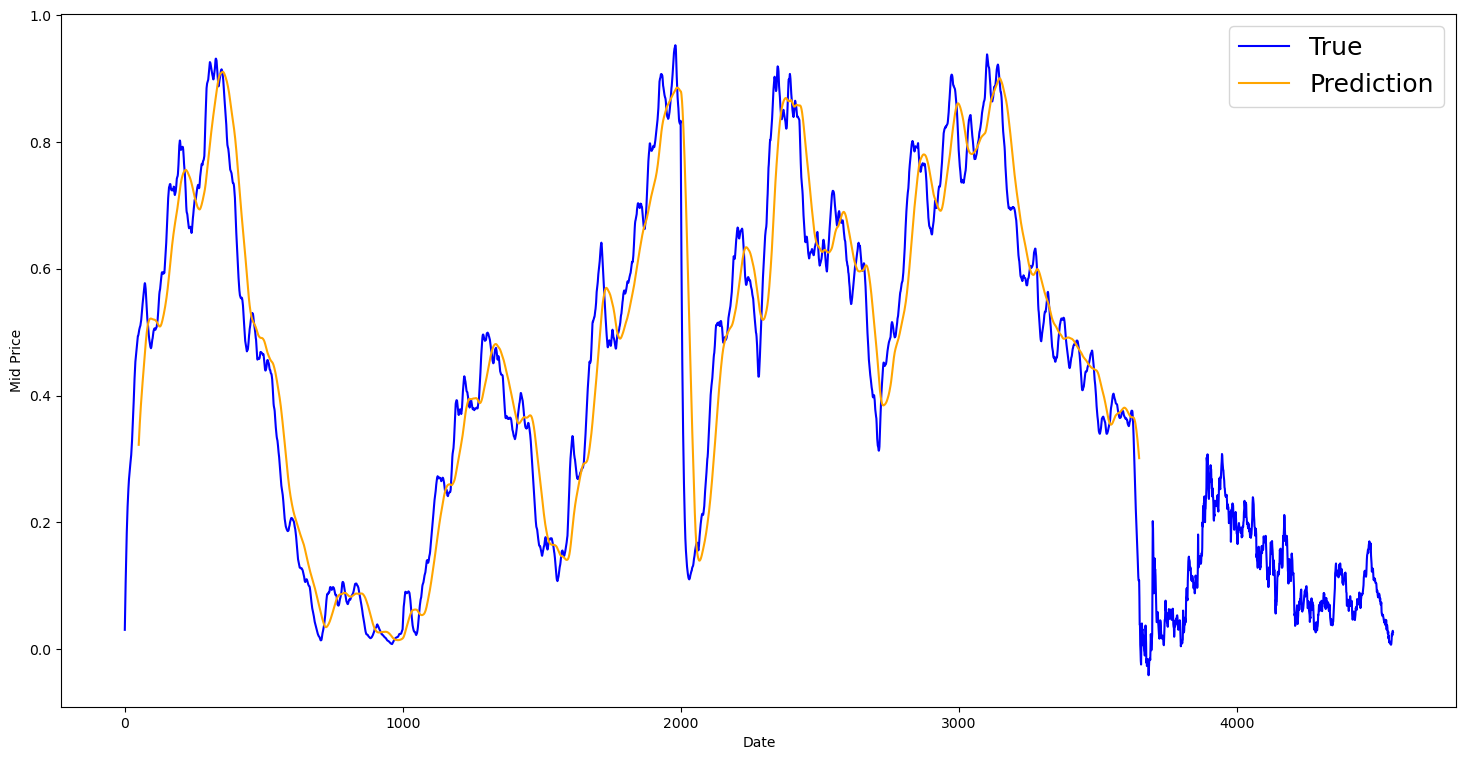

In [152]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


## Exponential Moving Average

In [161]:

N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00006


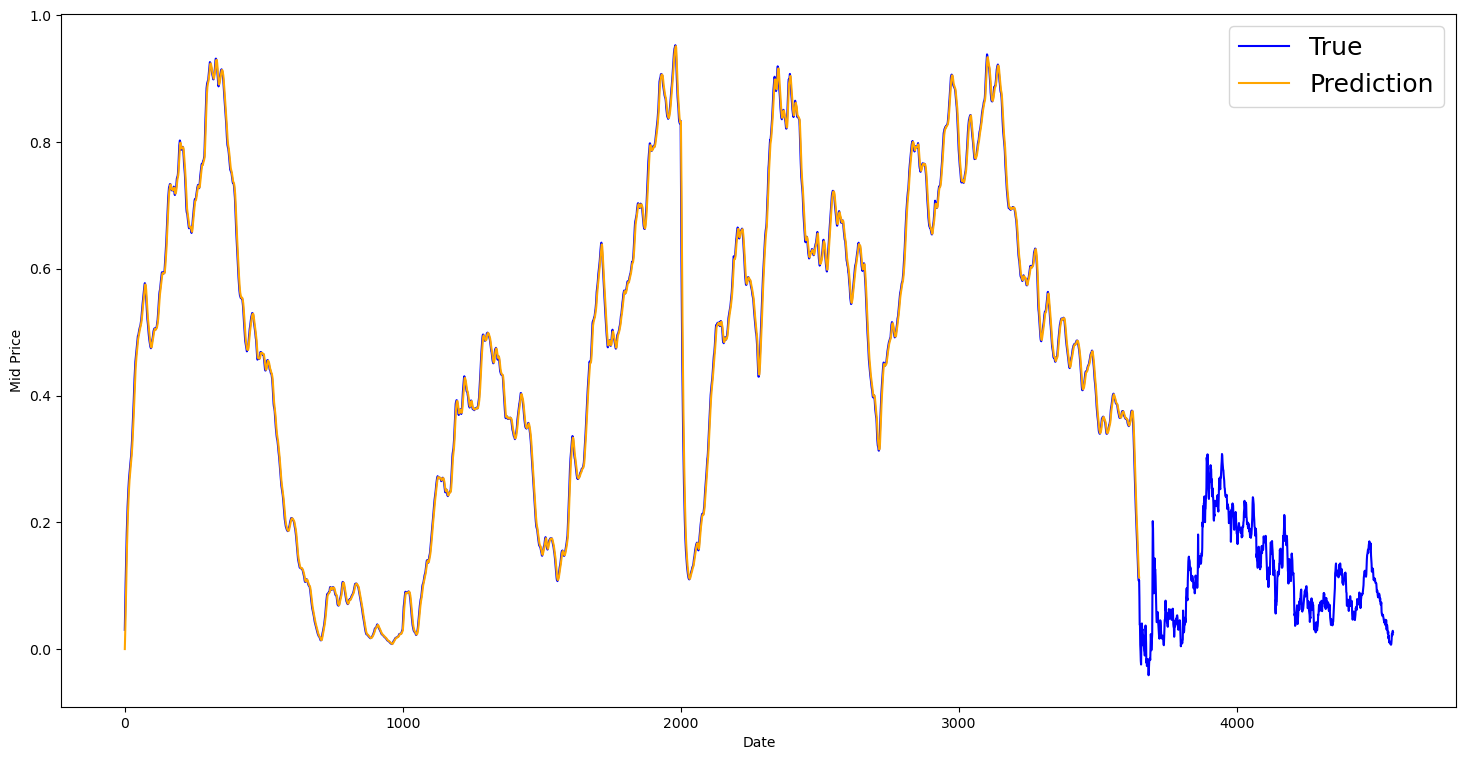

In [162]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


## LSTM

In [167]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))





In [179]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.03039658 0.08681563 0.3453     0.5711161  0.6924601 ]

	Output: [0.10475415 0.08681563 0.33803138 0.5711161  0.7008179 ]


Unrolled index 1
	Inputs:  [0.05712127 0.08710032 0.34139463 0.57898754 0.7008179 ]

	Output: [0.05712127 0.08878392 0.33357936 0.61480236 0.7008179 ]


Unrolled index 2
	Inputs:  [0.08195353 0.08635481 0.33803138 0.58823836 0.70751756]

	Output: [0.16563559 0.08943833 0.33357936 0.6070095  0.6961901 ]


Unrolled index 3
	Inputs:  [0.10475415 0.08731782 0.33357936 0.59732103 0.70503783]

	Output: [0.12644066 0.08878392 0.33357936 0.61480236 0.6986439 ]


Unrolled index 4
	Inputs:  [0.12644066 0.08878392 0.32799584 0.6070095  0.70280606]

	Output: [0.18349193 0.08878392 0.29951748 0.61788553 0.6986439 ]


## Define Hyperparameters

In [192]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times


## Training Proccess

In [200]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [201]:
# Input data.

train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [202]:
train_inputs

[<tf.Tensor 'train_inputs_0:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_1:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_2:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_3:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_4:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_5:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_6:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_7:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_8:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_9:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_10:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_11:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_12:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_13:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_14:0' shape=(500, 1) dtype=float32>,
 <tf.Tensor 'train_inputs_15:0' shape=(500, 1) dtype=float32>,
 <